In [3]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, plot_model
import cv2
import os

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
#read the image
# function to load the dataset and return the dataset list
# containing elements of format [scans, target]
targets = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(scans):
    data = list()
    for target in targets:
        #path holds the directory path of either train, test, or val and is joined with target which is either the PNEUMONIA folder or NORMAL folder to create the complete path. 
        path = os.path.join(scans, target)
        #class label holds 0 or 1 depending if PNEUMONIA is being read or NORMAL is.
        class_label = targets.index(target)
        for img in os.listdir(path):
            try:
                arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(arr, (img_size, img_size))
                data.append([resized_arr, class_label])
            except Exception as e:
                print(e)
    return np.array(data)

In [6]:
#extracting the dataset
train = get_training_data('/content/gdrive/MyDrive/PythonProjectWebApp/chest_xray/train')
test = get_training_data('/content/gdrive/MyDrive/PythonProjectWebApp/chest_xray/test')
val = get_training_data('/content/gdrive/MyDrive/PythonProjectWebApp/chest_xray/val')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [7]:
#split the data into training, testing and validation groups with variables to hold the target names.
images = []
labels = []

for image_scan, target in train:
    images.append(image_scan)
    labels.append(target)

for image_scan, target in test:
    images.append(image_scan)
    labels.append(target)

for image_scan, target in val:
    images.append(image_scan)
    labels.append(target)



In [8]:
# Normalize data
images = np.array(images) / 255

In [9]:
# resize data
images = images.reshape(-1, img_size, img_size, 1)
labels = np.array(labels)


In [10]:
images.shape
labels

array([0, 0, 0, ..., 1, 1, 1])

In [11]:
#prevents overfitting and handles the imbalance in dataset

data_aug = ImageDataGenerator(
        rotation_range = 30,  #rotate 
        zoom_range = 0.2, #  zoom  
        width_shift_range=0.1,  #  shift images horizontally 
        height_shift_range=0.1,  #  shift images vertically
        horizontal_flip = True,  # flip images
        vertical_flip=False)  # no vertical flip

data_aug.fit(images)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=.30, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.30, shuffle=True)

In [13]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(4099, 150, 150, 1)
(1229, 150, 150, 1)
(528, 150, 150, 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        3

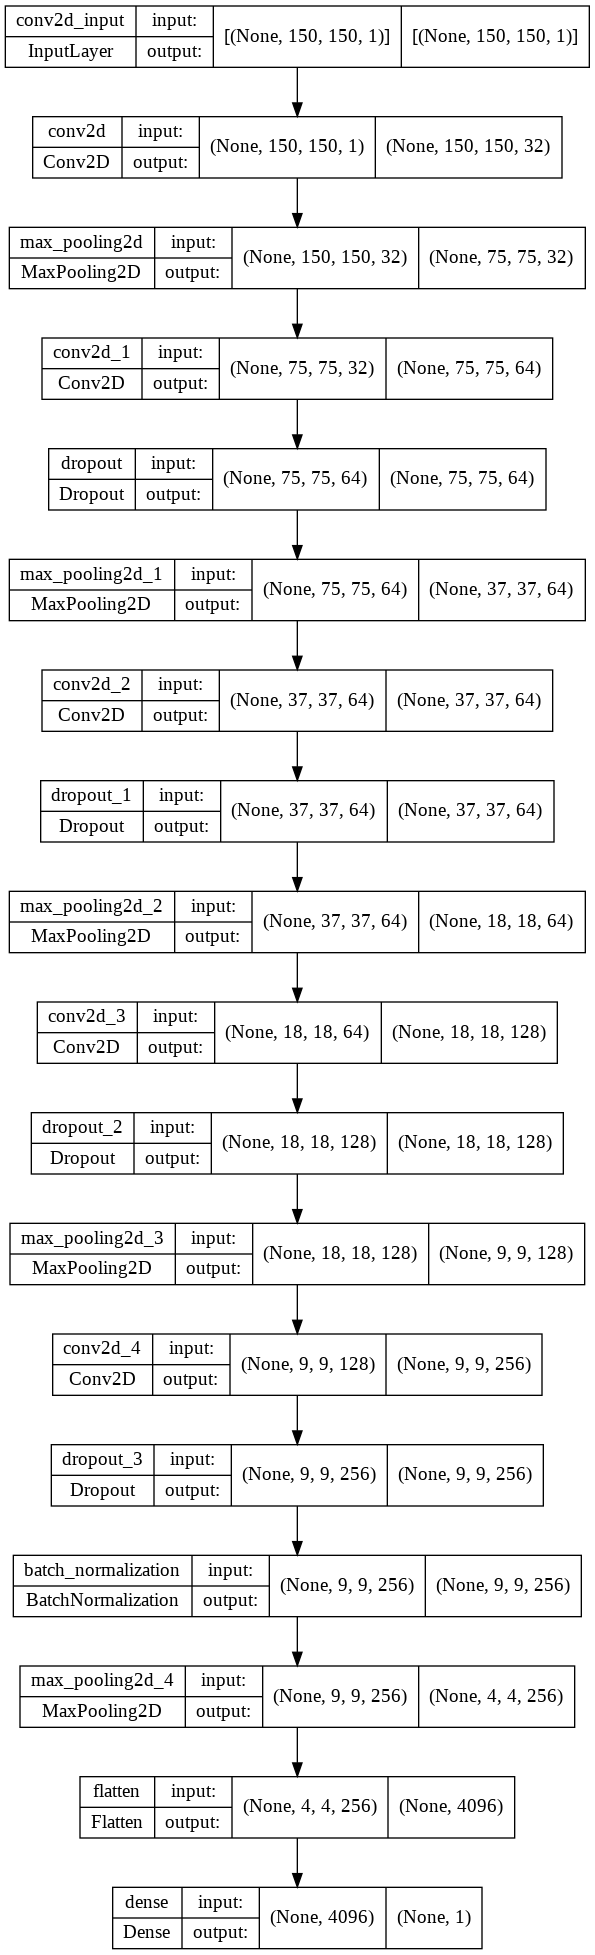

In [14]:
#building the model
cnn_model = Sequential()
cnn_model.add(Conv2D(32 , (3,3) , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
cnn_model.add(MaxPool2D((2,2) , strides = 2))

cnn_model.add(Conv2D(64 , (3,3) , padding = 'same' , activation = 'relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(MaxPool2D((2,2) , strides = 2))

cnn_model.add(Conv2D(64 , (3,3) , padding = 'same' , activation = 'relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(MaxPool2D((2,2) , strides = 2 ))

cnn_model.add(Conv2D(128 , (3,3) , padding = 'same' , activation = 'relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(MaxPool2D((2,2) , strides = 2))

cnn_model.add(Conv2D(256 , (3,3)  , padding = 'same' , activation = 'relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D((2,2) , strides = 2))

cnn_model.add(Flatten())

cnn_model.add(Dense(units = 1 , activation = 'sigmoid'))

cnn_model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['acc'])
cnn_model.summary()
plot_model(cnn_model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

In [15]:
#learning rate reduction
LRR = ReduceLROnPlateau(monitor='val_acc', patience = 2, verbose=1,factor=0.2, min_lr=0.0001)

In [16]:
history = cnn_model.fit(data_aug.flow(X_train, y_train, batch_size = 44) , epochs = 50 , validation_data = (X_test, y_test) , callbacks = [LRR])

Epoch 1/50
94/94 [==============================] - 22s 100ms/step - loss: 0.4186 - acc: 0.8090 - val_loss: 0.6517 - val_acc: 0.6062 - lr: 0.0010
Epoch 2/50
94/94 [==============================] - 8s 90ms/step - loss: 0.2826 - acc: 0.8839 - val_loss: 0.4579 - val_acc: 0.8991 - lr: 0.0010
Epoch 3/50
94/94 [==============================] - 8s 89ms/step - loss: 0.2731 - acc: 0.8870 - val_loss: 0.4394 - val_acc: 0.7217 - lr: 0.0010
Epoch 4/50
94/94 [==============================] - 8s 90ms/step - loss: 0.2414 - acc: 0.9012 - val_loss: 0.2311 - val_acc: 0.9439 - lr: 0.0010
Epoch 5/50
94/94 [==============================] - 8s 90ms/step - loss: 0.2579 - acc: 0.8927 - val_loss: 0.2868 - val_acc: 0.9439 - lr: 0.0010
Epoch 6/50
94/94 [==============================] - ETA: 0s - loss: 0.2343 - acc: 0.9056
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
94/94 [==============================] - 8s 89ms/step - loss: 0.2343 - acc: 0.9056 - val_loss: 1.1031 - val_acc:

In [17]:
cnn_model.save('PNmodel.h5')

In [18]:
cnn_model.evaluate(X_val,y_val)

17/17 [==============================] - 0s 19ms/step - loss: 0.1665 - acc: 0.9527


[0.16645899415016174, 0.9526515007019043]

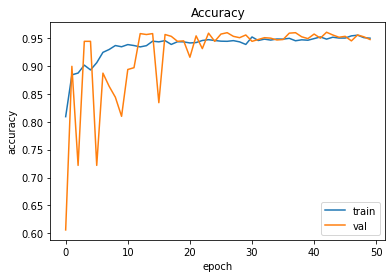

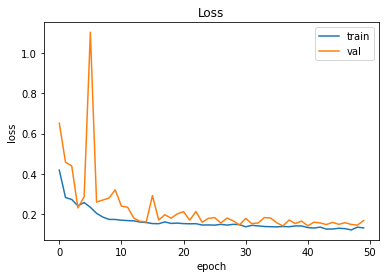

In [19]:
#plotting the data to demonstrate the accuracy of the train and validations. 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])
plt.show()

#plotting the data to demonstrate the loss of the train and validations. 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()